In [4]:
import pandas as pd
import datetime

# Load data
data1 = pd.read_csv('NQ_1min_continuous_adjusted.txt', names=["times", "open", "high", "low", "close", "volume"])

# Convert 'times' to datetime
data1['times'] = pd.to_datetime(data1['times'])

# Extract time from datetime for filtering
data1['time'] = data1['times'].dt.time
data1['date']= data1['times'].dt.date

# Filter for opening range and day range
opening_range = data1[(data1['time'] >= datetime.time(9, 30)) & (data1['time'] <= datetime.time(10, 29))]
open_to_close = data1[(data1['time'] >= datetime.time(9, 30)) & (data1['time'] <= datetime.time(15, 59))]


In [5]:
open_to_close = data1[(data1['time'] >= datetime.time(9, 30)) & (data1['time'] <= datetime.time(15, 59))]
data1_daily = open_to_close.groupby('date').agg(close=('close', 'last'),open=('open','first'))
data1_daily['prev_close'] = data1_daily['close'].shift(1)
data1_daily['gap'] = data1_daily['open'] -data1_daily['prev_close']

In [13]:
opening_range_stats = opening_range.groupby('date').agg( total_volume_ib = ('volume','sum'),high_ib=('high', 'max'), low_ib=('low', 'min'),open_ib=('open','first') ) # your aggregation here
opening_range_stats['opening_range_high_rel'] = opening_range_stats['high_ib'] - opening_range_stats['open_ib']
opening_range_stats['opening_range_low_rel'] = opening_range_stats['low_ib'] - opening_range_stats['open_ib']
opening_range_stats['atr_ib'] = opening_range.groupby('date').apply(lambda x: x['high'].max() - x['low'].min())
# Merge features into a single dataframe
features_df = opening_range_stats.merge(data1_daily, left_index=True, right_index=True, how='left')
# Calculate the correlation matrix
correlation_matrix = features_df.corr()
features_df

,total_volume_ib,high_ib,low_ib,open_ib,opening_range_high_rel,opening_range_low_rel,atr_ib,close,open,prev_close,gap
date,,,,,,,,,,,
2008-01-02,63123,2506.00,2488.75,2498.00,8.00,-9.25,17.25,2461.25,2498.00,NaN,NaN
2008-01-03,75091,2470.25,2452.00,2460.00,10.25,-8.00,18.25,2462.00,2460.00,2461.25,-1.25
2008-01-04,94984,2436.75,2413.50,2435.25,1.50,-21.75,23.25,2372.75,2435.25,2462.00,-26.75
2008-01-07,115195,2383.50,2348.50,2378.00,5.50,-29.50,35.00,2368.00,2378.00,2372.75,5.25
2008-01-08,99037,2391.75,2368.75,2372.50,19.25,-3.75,23.00,2318.25,2372.50,2368.00,4.50
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,118141,13134.00,13054.00,13077.50,56.50,-23.50,80.00,13059.25,13077.50,13088.25,-10.75
2023-04-25,132208,13015.50,12937.00,12988.25,27.25,-51.25,78.50,12808.50,12988.25,13059.25,-71.00
2023-04-26,143777,12967.50,12896.50,12950.25,17.25,-53.75,71.00,12882.50,12950.25,12808.50,141.75


In [14]:
# Define your target variable based on what you want to predict. For instance, if you want to predict whether the closing price is higher than the opening price:
features_df['target'] = (features_df['close'] - features_df['open'] > 0).astype(int)

# Select relevant features for the model
feature_columns = ['opening_range_high_rel', 'opening_range_low_rel', 'gap', 'total_volume_ib', 'atr_ib']  # Replace with your actual feature column names
final_feature_set = features_df[feature_columns + ['target']]
final_feature_set= final_feature_set.dropna()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'final_feature_set' is your DataFrame with all the features and target
X = final_feature_set[feature_columns].values
y = final_feature_set['target'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=( 1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Using sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary classification

# Reshape input data to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=1000, batch_size=32, validation_split=0.1) 


Epoch 1/1000
89/89 [==============================] - 4s 10ms/step - loss: 0.6793 - accuracy: 0.5876 - val_loss: 0.6638 - val_accuracy: 0.6203
Epoch 2/1000
89/89 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6494 - val_loss: 0.6526 - val_accuracy: 0.6361
Epoch 3/1000
89/89 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6786 - val_loss: 0.6468 - val_accuracy: 0.6677
Epoch 4/1000
89/89 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.6881 - val_loss: 0.6448 - val_accuracy: 0.6899
Epoch 5/1000
89/89 [==============================] - 0s 3ms/step - loss: 0.6042 - accuracy: 0.6937 - val_loss: 0.6335 - val_accuracy: 0.6930
Epoch 6/1000
89/89 [==============================] - 0s 3ms/step - loss: 0.5974 - accuracy: 0.6878 - val_loss: 0.6298 - val_accuracy: 0.6930
Epoch 7/1000
89/89 [==============================] - 0s 3ms/step - loss: 0.5989 - accuracy: 0.6944 - val_loss: 0.6276 - val_accuracy: 0.6867
Epoch

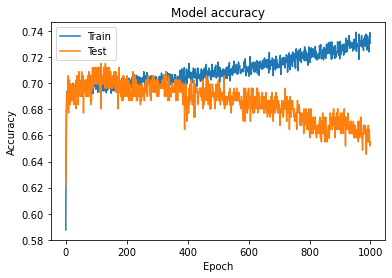

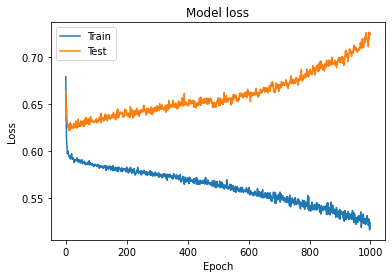

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()